## 2.6: Feature engineering


The process of feature engineering is of manipulating, transforming, selecting raw data into features that can be used in statistical analysis of prediction.

* statistical features
* temporal features
* spectral features (Fourier and Wavelet transforms)

We will first calculate some of the features individually on a seismic data set, then we will use a python toolbox to calculate them automatically.

In [1]:
# Import modules for seismic data and feature extraction

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.stats as st

# time series feature extraction python toolbox:
import tsfresh

# seismic python toolbox
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime


import h5py


First, we download seismic data from Puget Sound for a large M8.2 earthquake that happened in Alaska, July 29, 2021.

In [2]:
# Download seismic data
network = 'UW'
station = 'RATT'
channel = 'HHZ'# this channel gives a low frequency, 1Hz signal.
Tstart = UTCDateTime(2021,7,29,6,15)
Tend = Tstart+7200# UTCDateTime(year=2022, month=10, day=8)
fdsn_client = fdsn.Client('IRIS')
Z = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart, \
    endtime=Tend, attach_response=True)
Z.merge(); Z.detrend(type='linear')

1 Trace(s) in Stream:
UW.RATT..HHZ | 2021-07-29T06:15:00.000001Z - 2021-07-29T08:15:00.000001Z | 100.0 Hz, 720001 samples

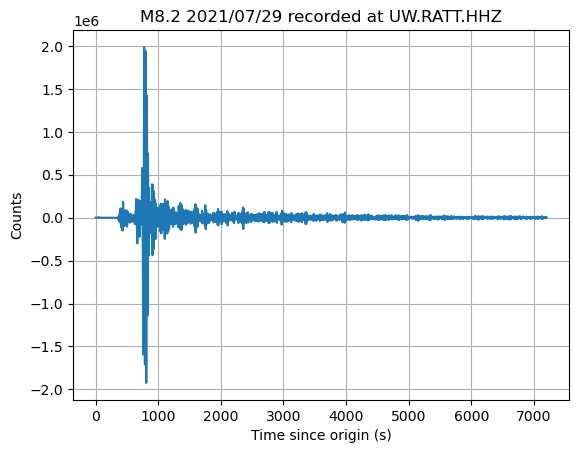

In [3]:
# plot the time series
T = np.linspace(0,(Tend-Tstart),Z[0].stats.npts)
plt.plot(T,Z[0].data)
plt.grid(True)
plt.xlabel('Time since origin (s)')
plt.title('M8.2 2021/07/29 recorded at UW.RATT.HHZ')
plt.ylabel('Counts')
plt.show()


Now, only seismologists work on obspy stream, so we will convert the data into numpy arrays:

In [4]:
z = np.asarray(Z[0].data)

To calculate the statistical features of the data, we will first look at the data distribution, P(z):

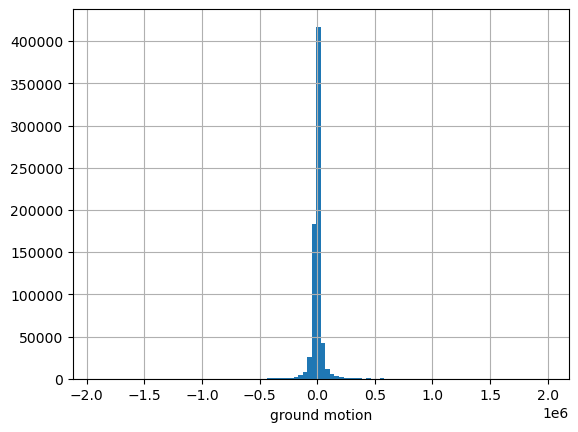

In [5]:
p = plt.hist(z,100);plt.grid(True);plt.xlabel('ground motion');plt.show()

We now calculated the distribution of the data, ``p``, in 100 bins.

## 2.6.2 Statistical Features

Let be $P(z)$ the distribution of the data $z$.

### The mean
<div>
<img src="mean.png" alt="mean" height=300  />
</div>

Image taken from this [blog](!https://gregorygundersen.com/blog/2020/04/11/moments).

The mean is the sum of the values divided by the number of data points. It is the first raw moment of a distribution. 
$\mu = \int_{-\infty}^\infty zP(z)dz$, where z the ground motion value (bin) and $P(z)$ is the distribution of the data.

### The Variance
 <div>
<img src="variance.png" alt="variance" height=200  />
</div>

The variance is the second *centralized* moment. *Centralized* means that the distribution is shifted around the mean. It calculates how spread out is a distribution.

$\sigma^2 = \int_{-\infty}^\infty (z-\mu)^2P(z)dz$

The standard deviation is the square root of the variance, $\sigma$. A high variance indicates a wide distribution.

### The skewness

Skewness is the third *standardized* moment. The *standardized* moment is scaled by the standard deviation. It measures the relative size of the two tails of the distribution.


$m_3= \int_{-\infty}^\infty \frac{(z - \mu)^3}{\sigma^3}P(z)dz$

With the cubic exponent, it is possible that the skewness is negative.

 <div>
<img src="skewness.png" alt="skewness" height=200  />
</div>

Image taken from this [blog](!https://gregorygundersen.com/blog/2020/04/11/moments).

A positively skewed distribution is one where most of the weight is at the end of the distribution. A negatively skewed distribution is one where most of the weight is at the beginning of the distribution.


### Kurtosis

Kurtosis measures the combine size of the two tails relative to the whole distribution. It is the fourth centralized and standardized moment.

$m_4= \int_{-\infty}^\infty (\frac{z-\mu}{\sigma})^4P(z)dz$

 <div>
<img src="kurtosis.png" alt="kurtosis" height=200  />
</div>
The laplace, normal, and uniform distributions have a mean of 0 and a variance of 1. But their kurtosis is 3, 0, and -1.2.


Python functions to calculate the moments might be:

In [6]:
def raw_moment(X, k, c=0):
    return ((X - c)**k).mean()

def central_moment(X, k):
    return raw_moment(X=X, k=k, c=X.mean())


We can now calculate the mean, variance, skewness, and kurtosis of the data:


In [7]:
# enter answers here using the functions for the moment.
# the mean:
print(raw_moment(z,1))

# the variance:
print(central_moment(z,2))

# the skewness
print(central_moment(z,3)/central_moment(z,2)**(3/2))

# the kurtosis
print(central_moment(z,4)/central_moment(z,2)**2)



-1.5586696440861216e-13
19059318218.65704
0.144572326613743
109.22237948156209


We can also use the numpy and scipy modules to get these values

In [8]:
print('the mean is %4.2f, the variance is %4.2f, the skewness is %4.2f, the kurtosis is %4.2f'
 %(np.mean(z),np.std(z)**2,scipy.stats.skew(z),scipy.stats.kurtosis(z,fisher=False)))

the mean is -0.00, the variance is 19059318218.66, the skewness is 0.14, the kurtosis is 109.22


These values may mean nothing without some additional context. We can download seismic noise data to see if the earthquake waveforms is statistically different from the noise. For that, we will download the same length of data prior to the earthquake:

In [9]:
# Download seismic data 2 hours prior to the earthquake.
# modify below.
N = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart-7200, \
    endtime=Tstart, attach_response=True)
N.merge(); N.detrend(type='linear')
n=np.asarray(N[0].data)

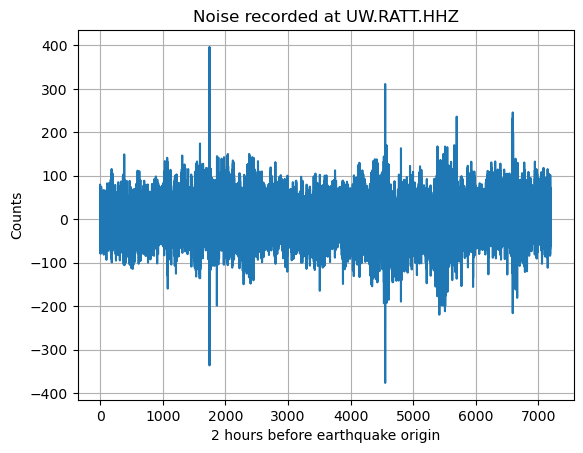

In [10]:
# plot the data
T = np.linspace(0,(Tend-Tstart),N[0].stats.npts)
plt.plot(T,n)
plt.grid(True)
plt.xlabel('2 hours before earthquake origin')
plt.title('Noise recorded at UW.RATT.HHZ')
plt.ylabel('Counts')
plt.show()

Calculate and plot the distribution of ground motion noise values:

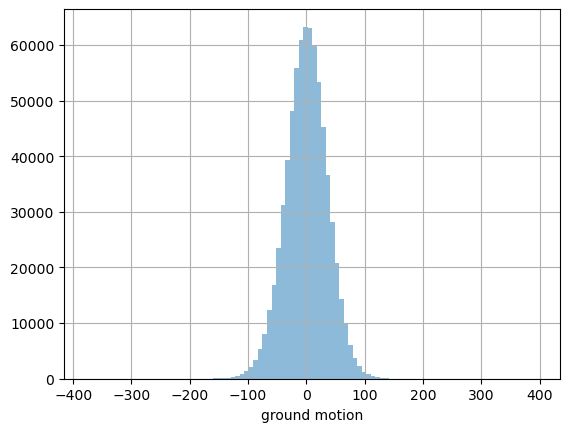

In [11]:
# type below
pn=plt.hist(n,100,alpha=0.5,label='noise');plt.grid(True);plt.xlabel('ground motion');plt.show()

In [12]:
print('the mean is %4.2f, the variance is %4.2f, the skewness is %4.2f, the kurtosis is %4.2f'
 %(np.mean(n),np.std(n)**2,scipy.stats.skew(n),scipy.stats.kurtosis(n,fisher=True)))

the mean is -0.00, the variance is 1273.08, the skewness is -0.09, the kurtosis is 0.39


Compare the values. You notice that for both quake and noise, the mean is small compared to absolute values; skewness is small (it's mostly symmetric). But the variance and the kurtosis are high for earthquakes. In fact, these two are used to detect earthquakes.


## 2.6.3 temporal features

These are calculated based on the time series, such as: absolute energy, autocorrelation, centroid, entropy, zero crossing rate etc.

## 2.6.4 Spectral features

The data can be projected onto series of orthogonal basis to represent the multiple scale of the data. The **Fourier transform** is the most utilized data transform to explore the frequencies that compose the signal.


#### Fourier Transform
We use the Scipy Fourier [package](!https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.rfft.html#scipy.fftpack.rfft) to transform the two time series (earthquake and noise).

The Fourier transform is a decomposition of the time series onto a orthonormal basis of cosine and sine functions. The Fourier transform of a time series $f(t)$ (but similarly if the variable is space $x$).

$\hat{F}(f) = \int_{-\infty}^\infty f(t) \exp^{-i2\pi ft} dt$

$\hat{F}(f)$ is the complex Fourier value at frequency $f$. The FOurier transform determines what frequency(ies) dominate the time series.


### Nyquist
The Fourier transform we will use in this class takes a discrete time series of real numbers. The time series is sampled with $N$ samples per seconds. If the time series span $T$ seconds regularly, then the sampling rate of the data $dt=T/N$. The highest frequency that can be resolved in a discrete time series, called the Nyquist frequency, is limited by $dt$:

$F_{Nyq} = \frac{1}{2dt N}$

Effectively, one cannot constrain signals within two time samples from the data.

### Uncertainties
* The discrete Fourier Transform yields an approximation of the FT. The shorter the time series, the least accurate is the FT. This means that the FT on short time windows is less accurate
* The FT assumes (and requires) the periodicity of the series, meaning that the finite/trimmed time series would repeat in time. To enforce this, we  **taper** the time series so that the first and last points are equal (to zero).

In [27]:
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len

npts = Z[0].stats.npts
## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(int(Z[0].data.shape[0])) # this will be an even number
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Z.taper(max_percentage=0.05)
Zhat = fft(Z[0].data,n=Nfft)#/np.sqrt(Z[0].stats.npts)


Please see the Obspy documentation to find out about the [taper](!https://docs.obspy.org/master/packages/autogen/obspy.core.trace.Trace.taper.html#supported-methods) function.
Plot the amplitude and phase spectra

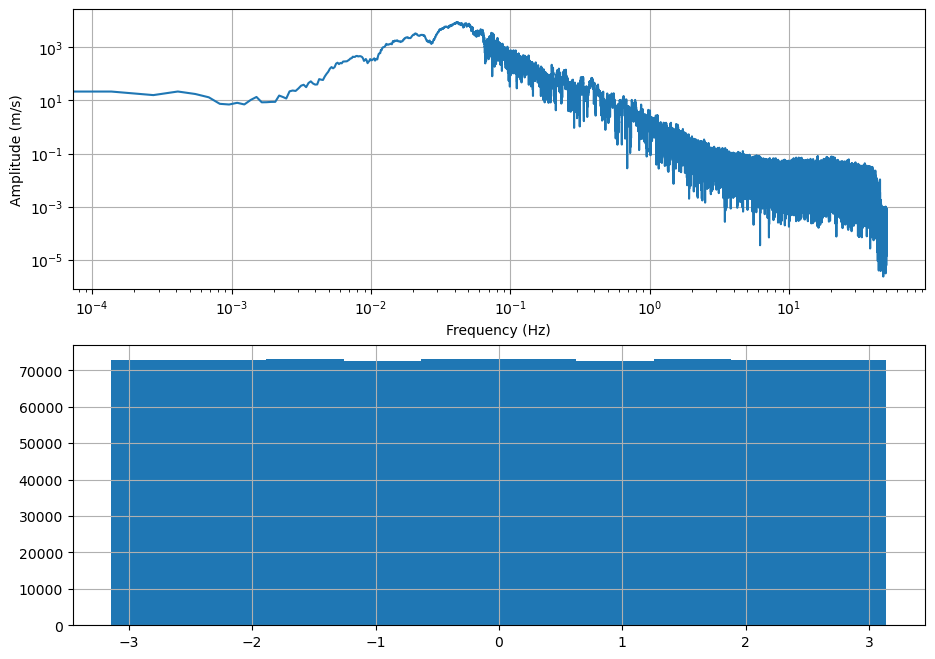

In [28]:
fig,ax=plt.subplots(2,1,figsize=(11,8))
ax[0].plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
ax[1].hist(np.angle(Zhat))
ax[1].grid(True)


You will note above that the phase values are randomly distributed between -pi and pi. We can check it by showing the distribution of the phase and amplitude spectra.


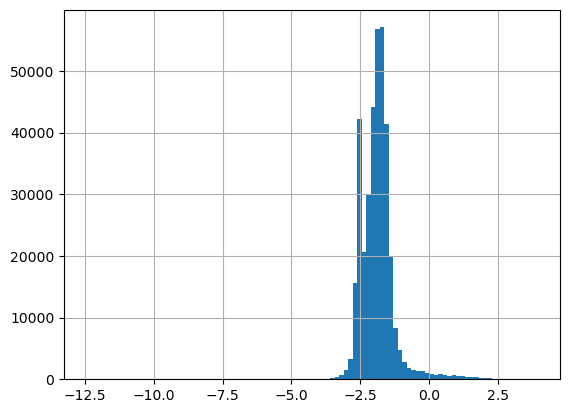

In [15]:
# your turn. Plot the histograms of the phase and amplitude spectrum
plt.hist(np.log10(np.abs(Zhat[:Nfft//2])/Nfft),100);plt.grid(True)
plt.show()

We can also analyze the spectral characteristics of the noise time series. Below, 
1. compute the Fourier transform
2. plot the phase and amplitude spectra
3. plot the distribution of the phase and amplitude values

In [30]:
# compute Fourier transform of the noise time series

npts1 = N[0].stats.npts
## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft1 = next_fast_len(int(N[0].data.shape[0])) # this will be an even number
freqVec1 = fftfreq(Nfft1, d=N[0].stats.delta)[:Nfft1//2]

# taper the data to enable periodicity
N.taper(max_percentage=0.05)

# Fourier transform
Nhat = fft(N[0].data,n=Nfft1)#/np.sqrt(Z[0].stats.npts)


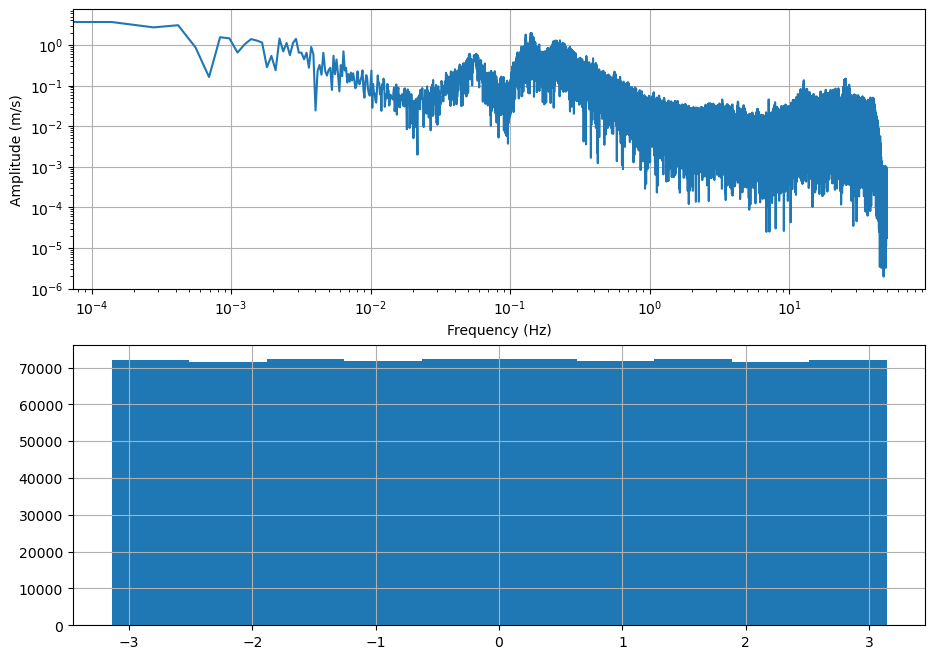

In [31]:
# plot the phase and amplitude spectra
fig,ax=plt.subplots(2,1,figsize=(11,8))
ax[0].plot(freqVec1,np.abs(Nhat[:Nfft1//2])/Nfft1)
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
ax[1].hist(np.angle(Nhat))
ax[1].grid(True)


(1e-05, 10000.0)

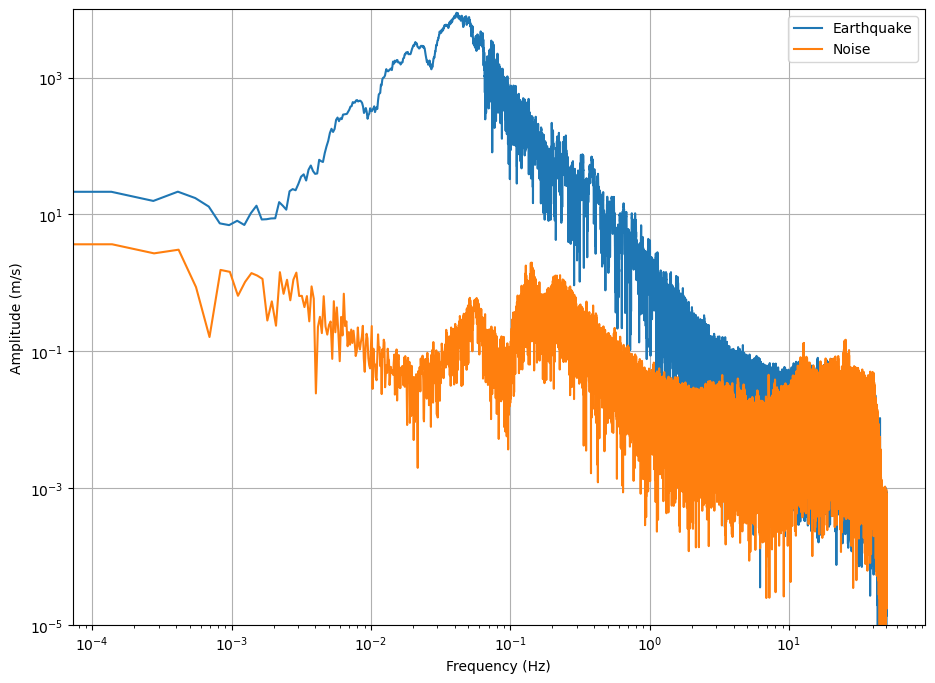

In [32]:
# Overlay the spectrum of the data and the spectrum of the noise

fig,ax=plt.subplots(1,1,figsize=(11,8))
ax.plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax.plot(freqVec1,np.abs(Nhat[:Nfft1//2])/Nfft1)
ax.grid(True)
ax.set_xscale('log');ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)');ax.set_ylabel('Amplitude (m/s)')
ax.legend(['Earthquake','Noise'])
ax.set_ylim([1e-5,1e4])


#### Short-Time Fourier Transform (SFTF)

In time-dependent and multi-scale problems, it may be interesting to extract data features from the short time Fourier transform.

The STFT is a Fourier Transform applied to short (overlapping) windows to resolve the frequencies over different times in the series.

1767563.2884356107
47.86349029869899


/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_18412/1691094658.py:8: RuntimeWarning: divide by zero encountered in log10
  ax[0].pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), vmin=-1, vmax=3.5, shading='gouraud')


(0.1, 40)

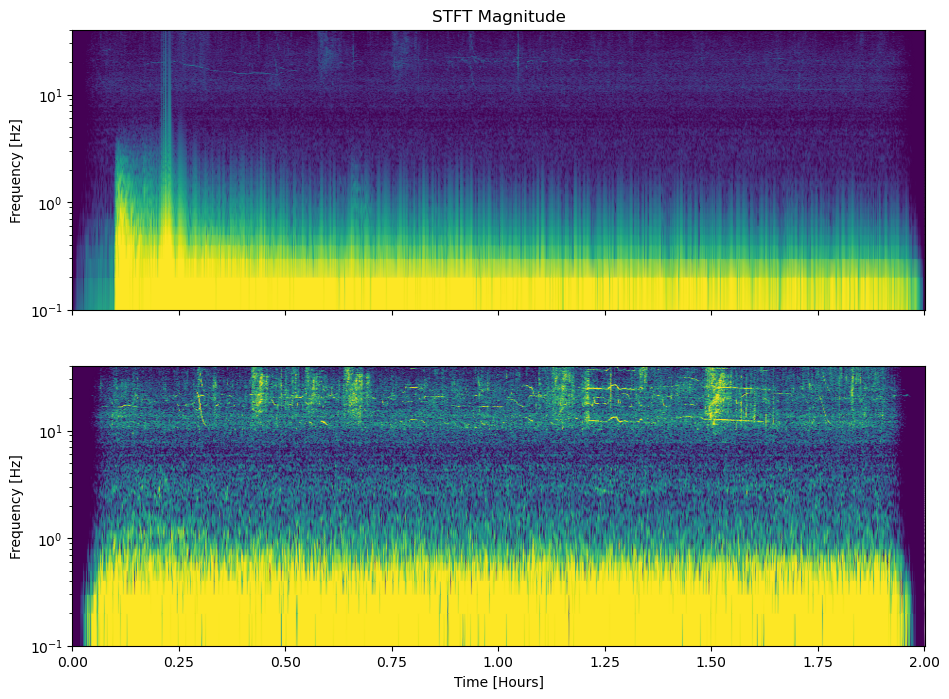

In [33]:
from scipy.signal import stft

nperseg=1000
z=np.asarray(Z[0].data)
f, t, Zxx = stft(z, fs=100, nperseg=nperseg,noverlap=200)
print(np.max(np.max(np.abs(Zxx))))
fig,ax=plt.subplots(2,1,figsize=(11,8),sharex=True)
ax[0].pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), vmin=-1, vmax=3.5, shading='gouraud')
ax[0].set_title('STFT Magnitude')
ax[0].set_ylabel('Frequency [Hz]')
# ax[0].set_xlabel('Time [Hours]')
ax[0].set_yscale('log');ax[0].set_ylim(0.1,40)


n=np.asarray(N[0].data)
f, t, Zxx = stft(n, fs=100, nperseg=nperseg,noverlap=200)
print(np.max(np.max(np.abs(Zxx))))
ax[1].pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), vmin=-1, vmax=0.5, shading='gouraud')
# ax[1].set_title('Noise Magnitude')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [Hours]');ax[1].set_yscale('log');ax[1].set_ylim(0.1,40)

#### Wavelet transform

The wavelet transform projects the time series onto a 2D space of *time* and *scale* axis. The *scale* is a representation of the frequency scale of the data. The waveletn transforms uses a series of functions called *wavelets* to linearly decompose the signals. Unlike the *sine* functions of the Fourier transform, the *wavelets* have finite durations and are localized in time:

 <div>
<img src="Wavelet-Out1.jpeg" alt="wavelet" height=100  />
</div>

Image from this [article](!https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/).

There exist many canonical wavelet families. The difference between families are typically their shape, compactness, and smoothness. Typically, one chooses one family for the specific time series. Wavelets have finite energy and zero mean.

The time-scale representation of of a time series is a *scaleogram*. *scales* can be converted to pseudo frequencies: If $f_c$ is the central frequency of the wavelet and the scale is $a$, then the pseuo-frequency is $f_a = f_c/a$.


 <div>
<img src="wavelet_families.png" alt="wavelet" height=300  />
</div>

Image from this [article](!https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/).

The wavelet transform becomes:

$\hat{F}(a,b) = \frac{1}{\sqrt{a}} \int_{-\infty}^\infty f(t) \bar{\Psi} (\frac{t-b}{a}) dt$

where $\bar{\Psi}$ is the mother wavelet scaled by a factor of $a$ and translated/shifted by $b$. The wavelet transform is scaled by the continuous and "infinite number of values" of $a$ and $b$ are continuous. The *Discrete Wavelet Transform* is the wavelet transform performed on a finite number of scales and shifts.

In [62]:
import scipy.signal as signal


t = np.arange(0,(Tend-Tstart)+Z[0].stats.delta,Z[0].stats.delta)
fs=1/Z[0].stats.delta

# use the number of scales
w = 6.

# relate scales with frequencies
# freq = np.linspace(0, fs/2, 100)
freq = np.logspace(-1, np.log10(fs/2), 100)
widths = w*fs / (2*freq*np.pi)


cwtm = signal.cwt(z, signal.morlet2, widths, w=w)

Calculating the time-frequency representation of large time series 

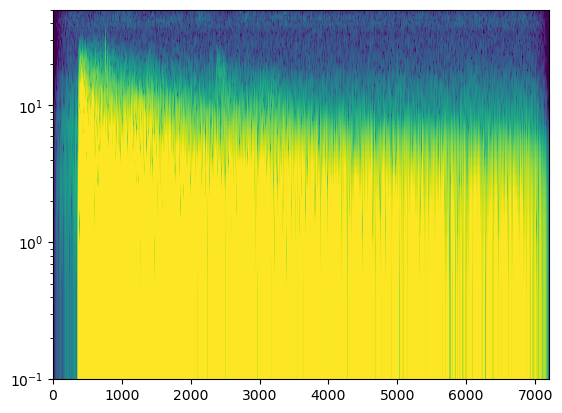

In [63]:

# cwtmatr = signal.cwt(z, signal.morlet, widths)
plt.imshow(np.log10(np.abs(cwtm)), extent=[t.min(),t.max(),freq.min(),freq.max()], cmap='viridis', aspect='auto',
           vmax=5, vmin=-0.5,origin='lower')
plt.yscale('log')
plt.show()

TF transforms take computational time in the workflow, let's compare:

In [64]:
%timeit cwtm = signal.cwt(z, signal.morlet2, widths, w=w)
%timeit f, t, Zxx = stft(n, fs=100, nperseg=nperseg,noverlap=200)


4.19 s ± 51.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.09 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


From these transform, we can extract similar statistical features

## Automated Feature Extraction

There are toolboxes to extract features from the data, including feautres done the tranfsform. We will use ``Tsfresh``, some of the best maintained and comprehensive python toolbox.

Most toolboxes require the input to be ``pandas``. First, we convert the data into pndas. 

In [77]:
import tsfresh
from tsfresh import extract_features

df=pd.DataFrame({'quake':z[:10],'noise':n[:10]})

In [78]:
df.head()

,quake,noise
0,0.000000e+00,0.000000e+00
1,1.846266e-07,2.521154e-16
2,6.547340e-07,3.453891e-15
3,1.164720e-06,1.572369e-14
4,2.527529e-06,5.897371e-14


In [79]:

extracted_features = extract_features(df, column_id="quake")

Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]/Users/marinedenolle/.conda/envs/mlgeo_sk/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/marinedenolle/.conda/envs/mlgeo_sk/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/marinedenolle/.conda/envs/mlgeo_sk/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/marinedenolle/.conda/envs/mlgeo_sk/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/marinedenolle/.conda/envs/mlgeo_sk/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=a

NotImplementedError: AR has been removed from statsmodels and replaced with statsmodels.tsa.ar_model.AutoReg.

In [ ]:
extracted_features.head()


# create synthetic noise